## **Chat Models**

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [7]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:qwen/qwen3-32b", temperature=0)

response = llm.invoke("test line")

In [8]:
response.content

'<think>\nOkay, the user sent "test line". That\'s pretty short. I need to figure out what they want. Maybe they\'re just checking if the system is working. Let me see. They might be testing the response time or if the AI is active. I should respond in a friendly way to acknowledge their test. Let me make sure to keep it open-ended in case they have more to say. Maybe something like, "Hello! It looks like you\'re testing the waters. How can I assist you today?" That should cover it. Let me check for any typos and ensure the tone is approachable.\n</think>\n\nHello! It looks like you\'re testing the waters. How can I assist you today? 😊'

In [9]:
type(response)

langchain_core.messages.ai.AIMessage

# **Tools**

In [10]:
from langchain.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send email."""

    return f"Email sent to {to} with subject {subject} and content: {content}"

In [11]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [12]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

## **Tools Binding**
- tool choice: `any`
    - Always have to tool calls from the available tools.

In [13]:
model_with_tools = llm.bind_tools(tools=[write_email], tool_choice="any", parallel_tool_calls=False)

output = model_with_tools.invoke("Draft a response to my MD sir about tomorrow's meeting")

In [14]:
output

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user wants me to draft a response to their MD sir about tomorrow\'s meeting. Let me start by understanding what they need. They probably need a professional email that confirms their attendance or discusses the meeting agenda.\n\nFirst, I should check if there are any specific details they want included. The user hasn\'t provided specifics, so I\'ll have to make some assumptions. The email should have a clear subject line, like "Confirmation of Attendance for Tomorrow\'s Meeting" or something similar.\n\nThe content should be polite, mention the meeting date, maybe the time and location if known. Since it\'s to the MD, it\'s important to maintain a respectful tone. I should also include a placeholder for any additional details the user might want to add, like agenda points or action items.\n\nWait, the user might need to add personal notes or specific requests. I\'ll structure the email with a friendly opening, a 

In [16]:
output.tool_calls[0]

{'name': 'write_email',
 'args': {'content': 'Dear MD Sir,\n\nI hope this email finds you well. I would like to confirm my attendance for the meeting scheduled tomorrow. Please let me know if there are any specific agenda items or preparations required from my side.\n\nLooking forward to your guidance.\n\nBest regards,\n[Your Name]',
  'subject': "Confirmation of Tomorrow's Meeting",
  'to': 'md@example.com'},
 'id': 'ybwkxd3k6',
 'type': 'tool_call'}

In [17]:
args = output.tool_calls[0]["args"]
args

{'content': 'Dear MD Sir,\n\nI hope this email finds you well. I would like to confirm my attendance for the meeting scheduled tomorrow. Please let me know if there are any specific agenda items or preparations required from my side.\n\nLooking forward to your guidance.\n\nBest regards,\n[Your Name]',
 'subject': "Confirmation of Tomorrow's Meeting",
 'to': 'md@example.com'}

In [18]:
result = write_email.invoke(args)

In [20]:
print(result)

Email sent to md@example.com with subject Confirmation of Tomorrow's Meeting and content: Dear MD Sir,

I hope this email finds you well. I would like to confirm my attendance for the meeting scheduled tomorrow. Please let me know if there are any specific agenda items or preparations required from my side.

Looking forward to your guidance.

Best regards,
[Your Name]


# ***LangGraph***

In [21]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

## **Write email Node**

In [22]:
def write_email_node(state: StateSchema) -> StateSchema:

    request = state["request"]
    output = model_with_tools.invoke(request)
    args = output.tool_calls[0]["args"]
    
    email = write_email.invoke(args)

    return {
        "email": email
    }

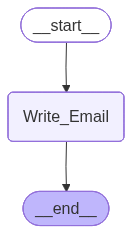

In [23]:
workflow.add_node("Write_Email", write_email_node)
workflow.add_edge(START, "Write_Email")
workflow.add_edge("Write_Email", END)

app = workflow.compile()
app

In [26]:
response = app.invoke(
    {
        "request": "Draft a response to my MD sir about tomorrow's meeting."
    }
)

response["email"]

"Email sent to md@example.com with subject Confirmation of Tomorrow's Meeting and content: Dear MD Sir, I hope this email finds you well. I just wanted to confirm our meeting scheduled for tomorrow. I am looking forward to discussing the agenda with you. Please let me know if there are any specific points you'd like to address. Best regards, [Your Name]"

## **Build the Actually Tools calls and Feedbacks**

In [50]:
from typing import Literal
from langgraph.graph import MessagesState

def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""
    print("---Call LLm---")
    message = state["messages"]

    output = model_with_tools.invoke(message)
    return {
        "messages": [output]
    }

In [51]:
def run_tool(state: dict):
    """Perform the tool call"""
    print("---Run Tool---")

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append(
            {
                "role": "tool",
                "content": observation,
                "tool_call_id": tool_call["id"]
            }
        )
    return {
        "messages": result
    }

In [52]:
def should_continue(state: MessagesState) -> Literal["run_tool", END]:
    """Route to tool handler, or end if Done tool called"""
    print("---Should Continue---")

    # ---extract last messages ---

    messages = state["messages"][-1]

    if messages.tool_calls:
        return "run_tool"
    return END



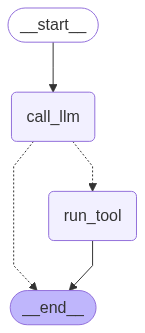

In [59]:
builder = StateGraph(MessagesState)

builder.add_node("call_llm", call_llm)
builder.add_node("run_tool", run_tool)

builder.add_edge(START, "call_llm")
builder.add_conditional_edges(
    "call_llm",
    should_continue,
    {
        "run_tool": "run_tool",
        END: END
    }
)
builder.add_edge("run_tool", END)

app = builder.compile()
app

In [61]:
response = app.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "write a email to my MD sir about tomorrow's meeting."
            }
        ]
    }
)

for msg in response["messages"]:
    msg.pretty_print()

---Call LLm---
---Should Continue---
---Run Tool---
================================ Human Message =================================

write a email to my MD sir about tomorrow's meeting.
================================== Ai Message ==================================
Tool Calls:
  write_email (429vth6hs)
 Call ID: 429vth6hs
  Args:
    content: Dear MD Sir,

I hope this email finds you well. I would like to confirm our meeting scheduled for tomorrow. Kindly let me know the specific time and any agenda points you'd like to discuss. I am looking forward to our discussion.

Best regards,
[Your Name]
    subject: Tomorrow's Meeting Discussion
    to: md@example.com
================================= Tool Message =================================

Email sent to md@example.com with subject Tomorrow's Meeting Discussion and content: Dear MD Sir,

I hope this email finds you well. I would like to confirm our meeting scheduled for tomorrow. Kindly let me know the specific time and any agenda poi

## **Create React Agent**

In [62]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Response to the user's request using the tools provided."
)

In [67]:
response = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Draft a response to my boss confirming that I want to attend Interrupt!"
            }
        ]
    }
)

In [68]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Draft a response to my boss confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (e9evrazkr)
 Call ID: e9evrazkr
  Args:
    content: Dear [Boss's Name],

I am writing to confirm my attendance at Interrupt! I am excited about the opportunity to attend and look forward to the insights and networking it will provide. Please let me know if there are any additional steps I need to take.

Best regards,
[Your Name]
    subject: Confirmation of Attendance at Interrupt!
    to: boss@example.com
================================= Tool Message =================================
Name: write_email

Email sent to boss@example.com with subject Confirmation of Attendance at Interrupt! and content: Dear [Boss's Name],

I am writing to confirm my attendance at Interrupt! I am excited about the opportunity to attend and look for

In [69]:
from langgraph.checkpoint.memory import InMemorySaver

from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Response to the user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config = {
    "configurable": {
        "thread_id": "1"
    }
}

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Write some good practices to write th emails."
            }
        ]
    },
    config=config
)

In [71]:
for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Write some good practices to write th emails.
================================== Ai Message ==================================

Here are some best practices for writing effective emails:

1. **Clear Subject Line**: Summarize the purpose concisely (e.g., "Project Update: Q3 Goals").
2. **Friendly Greeting**: Use "Hi [Name]" or "Dear [Name]" to personalize.
3. **Concise Content**: Keep paragraphs short; use bullet points for lists or key points.
4. **Tone**: Match the recipient's formality (professional for work, casual for friends).
5. **Call to Action**: Specify what you need (e.g., "Please confirm by Friday").
6. **Proofread**: Check for typos and clarity before sending.
7. **Sign Off**: Use "Best regards," "Sincerely," or "Thanks," followed by your name/contact info.

Example structure:
```
Subject: [Clear Summary]
Hi [Name],
[Opening line – context or purpose]
[Body – details/bullet points]
[Closing – 

In [72]:
state = agent.get_state(config=config)
for msg in state.values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Write some good practices to write th emails.
================================== Ai Message ==================================

Here are some best practices for writing effective emails:

1. **Clear Subject Line**: Summarize the purpose concisely (e.g., "Project Update: Q3 Goals").
2. **Friendly Greeting**: Use "Hi [Name]" or "Dear [Name]" to personalize.
3. **Concise Content**: Keep paragraphs short; use bullet points for lists or key points.
4. **Tone**: Match the recipient's formality (professional for work, casual for friends).
5. **Call to Action**: Specify what you need (e.g., "Please confirm by Friday").
6. **Proofread**: Check for typos and clarity before sending.
7. **Sign Off**: Use "Best regards," "Sincerely," or "Thanks," followed by your name/contact info.

Example structure:
```
Subject: [Clear Summary]
Hi [Name],
[Opening line – context or purpose]
[Body – details/bullet points]
[Closing – 

## **Continue Conversation**

In [73]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Good, let's use lesson 3 to craft a response to my boos confirming that i want to attend Interrupt"
            }
        ]
    },
    config=config
)

In [74]:
for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Write some good practices to write th emails.
================================== Ai Message ==================================

Here are some best practices for writing effective emails:

1. **Clear Subject Line**: Summarize the purpose concisely (e.g., "Project Update: Q3 Goals").
2. **Friendly Greeting**: Use "Hi [Name]" or "Dear [Name]" to personalize.
3. **Concise Content**: Keep paragraphs short; use bullet points for lists or key points.
4. **Tone**: Match the recipient's formality (professional for work, casual for friends).
5. **Call to Action**: Specify what you need (e.g., "Please confirm by Friday").
6. **Proofread**: Check for typos and clarity before sending.
7. **Sign Off**: Use "Best regards," "Sincerely," or "Thanks," followed by your name/contact info.

Example structure:
```
Subject: [Clear Summary]
Hi [Name],
[Opening line – context or purpose]
[Body – details/bullet points]
[Closing – 

In [75]:
state = agent.get_state(config=config)
for msg in state.values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Write some good practices to write th emails.
================================== Ai Message ==================================

Here are some best practices for writing effective emails:

1. **Clear Subject Line**: Summarize the purpose concisely (e.g., "Project Update: Q3 Goals").
2. **Friendly Greeting**: Use "Hi [Name]" or "Dear [Name]" to personalize.
3. **Concise Content**: Keep paragraphs short; use bullet points for lists or key points.
4. **Tone**: Match the recipient's formality (professional for work, casual for friends).
5. **Call to Action**: Specify what you need (e.g., "Please confirm by Friday").
6. **Proofread**: Check for typos and clarity before sending.
7. **Sign Off**: Use "Best regards," "Sincerely," or "Thanks," followed by your name/contact info.

Example structure:
```
Subject: [Clear Summary]
Hi [Name],
[Opening line – context or purpose]
[Body – details/bullet points]
[Closing – 

## **Interrupts**
- Stop graph execution at specific point

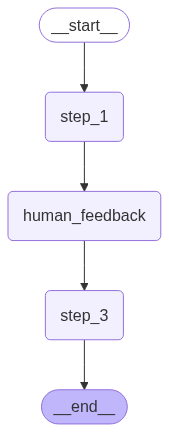

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

class State(TypedDict):
    input: str
    user_feedback: str

def step_1(state):
    print("---Step 1---")
    pass

def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}

def step_3(state):
    print("---Step 3---")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = InMemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

In [87]:
# Input
initial_input = {"input": "test line"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', id='435caa29de218a454b8ce4647bb93073'),)}




## **Resume the Interrupt**
- use Command object

In [88]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}


